In [246]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from graphviz import Digraph
import dtale
import xgboost as xgb
from skopt import gp_minimize
from skopt.space import Real, Integer
from functools import partial
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [342]:
cols = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConcl', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'Class']
df = pd.read_csv(r'magic04.csv', header=None, names = cols)
df.loc[df['Class'] == 'g', ['Class']] = 1
df.loc[df['Class'] == 'h', ['Class']] = 0
df['Class'] = df['Class'].astype(int)
df['dim1'] = df['fLength']/(-67 + 40*df['fSize'])
df['dim2'] = df['fWidth']/(27.9 - 22.5*df['fSize'] +6.7*df['fSize']**2)
df['dim3'] = df['fSize']/(df['fLength']*df['fWidth'])
df1 = df[df['dim3'] < 1]
#df2 = df1[df1['fAlpha'] < 10]
#df3 = df2[df2['dim1'] < 1.35]
#df4 = df3[df3['dim2'] < 1.12]
df.head()

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class,dim1,dim2,dim3
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1,0.742260,1.048660,0.005740
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1,0.936680,0.853811,0.006797
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1,1.697804,2.892528,0.000184
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1,0.897408,0.802868,0.010257
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1,1.263983,1.303268,0.001361


In [352]:
train, test, validate = np.split(df1.sample(frac=1), [int(.6*len(df1)), int(.8*len(df1))])
print(train.shape, test.shape, validate.shape)

(11331, 14) (3777, 14) (3777, 14)


In [353]:
y_train = train['Class']
x_train = train.drop(['Class'], axis=1)
y_test = test['Class']
x_test = test.drop(['Class'], axis=1)
y_validate = validate['Class']
x_validate = validate.drop(['Class'], axis=1)

In [354]:
x_train.columns

Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConcl', 'fAsym', 'fM3Long',
       'fM3Trans', 'fAlpha', 'fDist', 'dim1', 'dim2', 'dim3'],
      dtype='object')

In [355]:
y_test.mean()

0.6441620333598094

In [356]:
y_train.mean()

0.6554584767452123

In [357]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True))

Features sorted by their score:
[(0.2092, 'fAlpha'), (0.1248, 'dim2'), (0.091, 'fLength'), (0.0905, 'dim3'), (0.0755, 'fSize'), (0.0712, 'fWidth'), (0.0651, 'dim1'), (0.0642, 'fM3Long'), (0.0522, 'fDist'), (0.0441, 'fConc'), (0.0414, 'fConcl'), (0.0366, 'fAsym'), (0.0341, 'fM3Trans')]


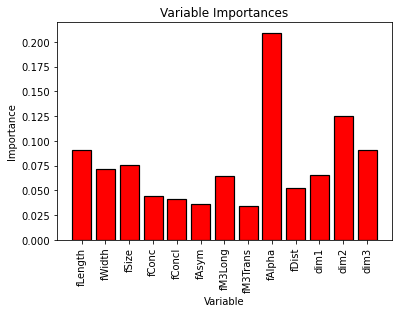

In [358]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, x_train.columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [359]:
# Instantiate
rf = RandomForestClassifier(n_estimators = 50)
# Fit
rf_model = rf.fit(x_train, y_train)
# training accuracy
rf_model.score(x_train, y_train)
print(rf_model.score(x_train, y_train))

# Predictions/probs on the test dataset
predicted = pd.DataFrame(rf_model.predict(x_test))
probs = pd.DataFrame(rf_model.predict_proba(x_test))

# Store metrics
rf_accuracy = metrics.accuracy_score(y_test, predicted)     
rf_roc_auc = metrics.roc_auc_score(y_test, probs[1])       
rf_confus_matrix = metrics.confusion_matrix(y_test, predicted) 
rf_classification_report = metrics.classification_report(y_test, predicted)
rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)
rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)
rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
rf_cv_scores = cross_val_score(RandomForestClassifier(n_estimators = 50), x_test, y_test, scoring='precision', cv=10)
rf_cv_mean = np.mean(rf_cv_scores)

print(metrics.classification_report(y_test, predicted))
print(rf_cv_mean)

0.9997352396081546
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1344
           1       0.89      0.94      0.91      2433

    accuracy                           0.89      3777
   macro avg       0.88      0.86      0.87      3777
weighted avg       0.88      0.89      0.88      3777

0.8802322697831141


In [360]:
print(rf_accuracy, rf_roc_auc, rf_precision, rf_recall, rf_f1)

0.8850939899391052 0.9356459972501125 0.8881553398058253 0.9399917796958488 0.9133386581469649


In [243]:
#Hyperparameter optimization
param_grid = {'bootstrap': [True, False],
     'max_depth': (1,2,3,4,5,6,7,8,9,10),
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1,2,3,4,5],
     'min_samples_split': [1,2,3,4,5,6],
     'n_estimators': [50]
    }
     

forest_clf = RandomForestClassifier()

forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 33.7min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [50]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [244]:
forest_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 50}

In [361]:
#XGBoost
gbm = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.42558304788181384,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.25628132290009864,
              max_delta_step=6.153985737570238, max_depth=2,
              min_child_weight=12.540582759253521,
              monotone_constraints='()', n_estimators=632, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=19.50796795585303,
              reg_lambda=7.186997608292775, scale_pos_weight=1, seed=42,
              subsample=0.5190351481641665, tree_method='exact',
              validate_parameters=1, verbosity=None)

eval_set=[(x_train, y_train),(x_validate, y_validate)]
gb_model = gbm.fit( 
                    x_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

# training accuracy
gb_model.score(x_train, y_train)
print(gb_model.score(x_train, y_train))

# Predictions/probs on the test dataset
predicted = pd.DataFrame(gb_model.predict(x_test))
probs = pd.DataFrame(gb_model.predict_proba(x_test))

# Store metrics
gb_accuracy = metrics.accuracy_score(y_test, predicted)     
gb_roc_auc = metrics.roc_auc_score(y_test, probs[1])       
gb_confus_matrix = metrics.confusion_matrix(y_test, predicted) 
gb_classification_report = metrics.classification_report(y_test, predicted)
gb_precision = metrics.precision_score(y_test, predicted, pos_label=1)
gb_recall = metrics.recall_score(y_test, predicted, pos_label=1)
gb_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

# Evaluate the model using 10-fold cross-validation
gb_cv_scores = cross_val_score(xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.42558304788181384,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.25628132290009864,
              max_delta_step=6.153985737570238, max_depth=2,
              min_child_weight=12.540582759253521,
              monotone_constraints='()', n_estimators=632, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=19.50796795585303,
              reg_lambda=7.186997608292775, scale_pos_weight=1, seed=42,
              subsample=0.5190351481641665, tree_method='exact',
              validate_parameters=1, verbosity=None), x_test, y_test, scoring='precision', cv=10)
gb_cv_mean = np.mean(gb_cv_scores)

print(metrics.classification_report(y_test, predicted))
print(gb_cv_mean)

0.8795340217103521
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1344
           1       0.87      0.94      0.91      2433

    accuracy                           0.87      3777
   macro avg       0.88      0.85      0.86      3777
weighted avg       0.87      0.87      0.87      3777

0.865013083532123


In [362]:
print(gb_accuracy, gb_roc_auc, gb_precision, gb_recall, gb_f1)

0.8734445326979083 0.9279374743115495 0.8709677419354839 0.9432799013563502 0.9056827150749803


In [ ]:
#XGBoost hyperparameter optimization

In [206]:
space = [
    Real(0.01, 1, name="gamma"),
    Real(0.0001, 1, name="learning_rate"),
    Real(0.1, 10, name="max_delta_step"),
    Integer(1, 15, name="max_depth"),
    Real(10, 500, name="min_child_weight"),
    Integer(10, 1000, name="n_estimators"),
    Real(0.1, 100, name="reg_alpha"),
    Real(0.1, 100, name="reg_lambda"),
    Real(0.4, 0.7, name="subsample"),
]

In [207]:
def return_model_assessment(args, x_train, y_train, x_test):
    global models, train_scores, test_scores, curr_model_hyper_params
    params = {curr_model_hyper_params[i]: args[i] for i, j in enumerate(curr_model_hyper_params)}
    model = XGBClassifier(random_state=42, seed=42)
    model.set_params(**params)
    fitted_model = model.fit(x_train, y_train, sample_weight=None)
    models.append(fitted_model)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    train_score = f1_score(train_predictions, y_train)
    test_score = f1_score(test_predictions, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    return 1 - test_score

In [210]:
models = []
train_scores = []
test_scores = []
curr_model_hyper_params = ['gamma', 'learning_rate', 'max_delta_step',
                        'max_depth', 'min_child_weight', 'n_estimators', 'reg_alpha', 'reg_lambda', 'subsample']
objective_function = partial(return_model_assessment, x_train=x_train, y_train=y_train, x_test=x_test)

# running the algorithm
n_calls = 50 # number of times you want to train your model
results = gp_minimize(objective_function, space, base_estimator=None, n_calls=50, n_random_starts=n_calls-1, random_state=42)

In [239]:
import plotly.express as px
metrics = pd.DataFrame(train_scores + test_scores)
metrics.loc[:,'dataset'] = ["train_score"]*n_calls + ["test_score"]*n_calls
metrics.loc[:,'Iteration Number'] = list(range(1,n_calls+1)) + list(range(1,n_calls+1))
metrics.columns = ["F1 Score", "dataset", "Iteration Number"]
fig = px.line(metrics, x="Iteration Number", y="F1 Score", color="dataset")
fig.show()

In [237]:
print(models[30])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.42558304788181384,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.25628132290009864,
              max_delta_step=6.153985737570238, max_depth=2,
              min_child_weight=12.540582759253521, missing=nan,
              monotone_constraints='()', n_estimators=632, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=19.50796795585303,
              reg_lambda=7.186997608292775, scale_pos_weight=1, seed=42,
              subsample=0.5190351481641665, tree_method='exact',
              validate_parameters=1, verbosity=None)
